In [32]:
# https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8

In [2]:
"""
IN THIS NOTEBOOK:
A VAE ENCODES VIDEO AND JOINT ANGLES TOGETHER INTO A LATENT REPRESENTATION OF SIZE 20 (16 JOINTS, NO COMPRESSION,
+ VIDEO 64X64 INTO A 4D REPRESENTATION)
THEN USEs THE LATENT REPRESENTATIONS OBTAINED BY FORWARDING THROUGH THE VAE THE FIRST FRAME 
IN A SEQUENCE AND THE JOINT ANGLES AT TIME 0, AS __ THE HIDDEN STATES __ FOR THE RNN

THE (DETERMNISTIC) RNN SIMILARLY TO THE THE VAE TAKES VISUAL AND MOTOR INPUT, BUT INSTEAD AT ITS BOTTLENECK IT HAS A RECURRENT
LAYER.

"""

'\nIN THIS NOTEBOOK:\nA VAE ENCODES VIDEO AND JOINT ANGLES TOGETHER INTO A LATENT REPRESENTATION OF SIZE 20 (16 JOINTS, NO COMPRESSION,\n+ VIDEO 64X64 INTO A 4D REPRESENTATION)\nTHEN WE USE THE LATENT REPRESENTATIONS OBTAINED BY FORWARDING THROUGH THE VAE THE FIRST FRAME \nIN A SEQUENCE AND THE JOINT ANGLES AT TIME 0, AS __ THE HIDDEN STATES __ FOR THE RNN\n\nTHE (DETERMNISTIC) RNN SIMILARLY TO THE THE VAE TAKES VISUAL AND MOTOR INPUT, BUT INSTEAD AT ITS BOTTLENECK IT HAS A RECURRENT\nLAYER.\n\n'

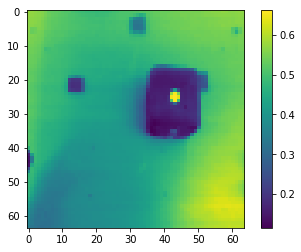

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns

from RNNxp import vaeRNN

import sys
import time
import random
import numpy as np
import cv2  # conda install opencv
import pickle


import matplotlib.pyplot as plt
from tabulate import tabulate
from utils import printProgressBar

def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()


class Dataloader():
    """
    loads a random trajectory, reshapes, normalizes, converst to torch tensors
    """
    def __init__(self):
        self.DAT = []
        self.TRAJECTORIES = ['RAD0.dat', 'RAD1.dat', 'RAD2.dat']
        for traj in self.TRAJECTORIES:
            with open(traj, 'rb') as f:
                self.DAT.append(pickle.load(f))
        
    def get_sample(self, device):

        dat = random.choice(self.DAT)

        # normalize the data and create inpus and targets for video
        trn_V = dat['img'][:-1,:,:,:]/255.
        trg_V = dat['img'][1:,:,:,:]/255.

        # ... and for joints
        trn_P = dat['joints'][:-1,:]/2.
        trg_P = dat['joints'][1:,:]/2.

        visual_input = torch.tensor(trn_V, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device)/3.
        motor_input = torch.tensor(trn_P, dtype=torch.float).view(-1, 16).to(device)
        visual_target = torch.tensor(trg_V, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device)/3.
        motor_target = torch.tensor(trg_P, dtype=torch.float).view(-1, 16).to(device)

        # return trn_V, trg_V, trn_P, trg_P
        return visual_input, motor_input, visual_target, motor_target 


device = 'cuda'
dl = Dataloader()

%matplotlib inline

visual_input, _, _, _ = dl.get_sample(device)
plt.imshow(visual_input.cpu()[0].squeeze())
plt.colorbar()

# VAE with conv-deconv layers

In [4]:

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()                  # extend the functionality of previously built classes.

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=(1,1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=(1,1))
        
        self.fc1 =   nn.Linear(4096, 100)
        
        self.fcmu = nn.Linear(116, latent_dim)
        self.fcsig = nn.Linear(116, latent_dim)
        
        self.fc2 =   nn.Linear(latent_dim, 1024)
        self.fc3 =   nn.Linear(latent_dim, 16)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6, stride=2)


        self.optimizer = optim.RMSprop(self.parameters(), lr=0.00001)        
    
    def reparameterize(self, mu, logsig, train):
        std = torch.exp(logsig)*0.5                     # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        eps = torch.randn_like(std)
        return mu + eps*std if train else mu   

    def KL(self, mu, logsig):
        Dkl = - 0.5 * torch.sum(1.0 + logsig - mu.pow(2) - logsig.exp())
        return Dkl 
    
    def forward(self, visual_input, motor_input, train):
        # visual pathway:
        out = F.relu(self.conv1(visual_input))                          # torch.Size([?, 7, 64, 64])
        out = F.relu(self.conv2(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv3(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv4(out))                                   # torch.Size([?, 28, 32, 32])

        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3])   # torch.Size([?, 7168])
        out = F.relu(self.fc1(out))                                     # torch.Size([?, 500])
              
        vis_motor = torch.cat((out, motor_input), dim=1)
              
        mu = self.fcmu(vis_motor)                                       # torch.Size([?, 46])      
        logsig = self.fcsig(vis_motor)                                  # torch.Size([?, 46])
        
        latent = self.reparameterize(mu, logsig, train=train)           # torch.Size([?, 1, 46])
        
        out1 = F.relu(self.fc2(latent).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                               # torch.Size([?, 64])
        video_out = torch.sigmoid(self.deconv4(out1))                   # torch.Size([?, 64])
        
        # predict motor output based on the latent representation:
        motor_out = torch.tanh(self.fc3(latent))

        return video_out, motor_out, mu, logsig
    
    def reconstruct(self, mu):
        out1 = F.relu(self.fc2(mu).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                              # torch.Size([?, 64])
        out1 = torch.sigmoid(self.deconv4(out1))                       # torch.Size([?, 64])
        return out1

In [5]:
latent_dim  = 20 # 2 for units to encode video (cube position), 16 to encode joints
device = 'cuda'
vae = VAE(latent_dim).to(device)
# vae.load_state_dict(torch.load('checkpoint_vae_hidden_states_1'))

<IPython.core.display.Javascript object>


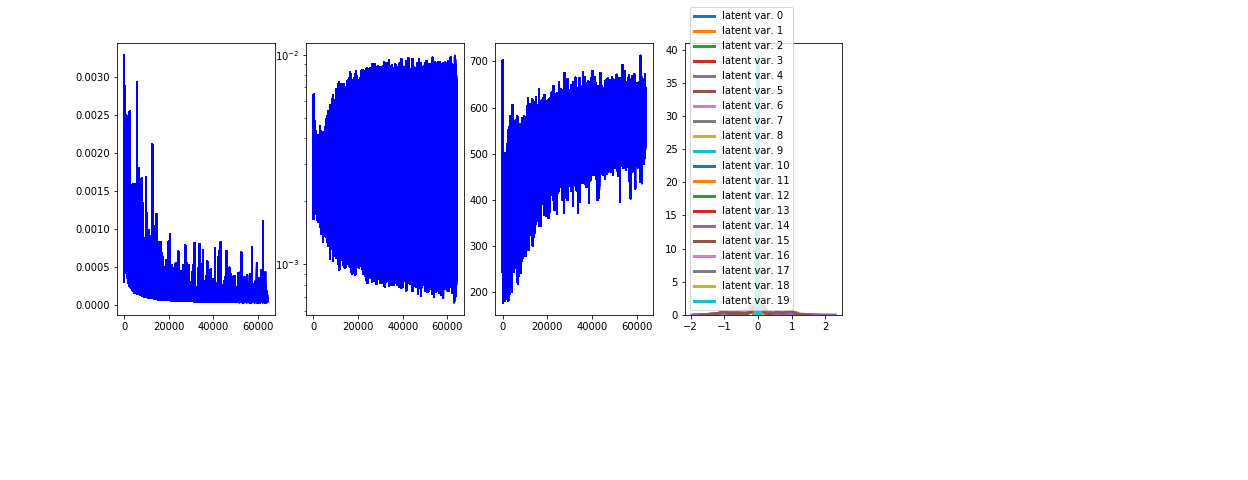

Epoch: 64244 vloss: 0.0001 kloss: 521.244080 |███----------------------| 12.8% Complete
Stopped


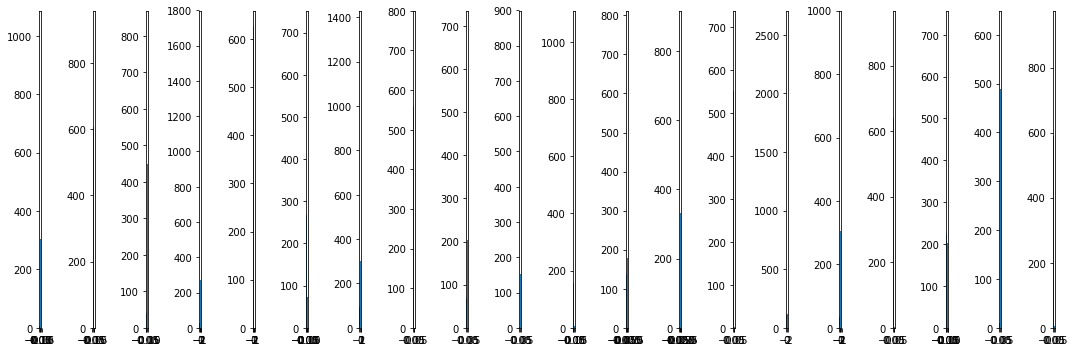

In [13]:
EPOCHS = 500000


%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.figsize'] = [20, 5]
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(13,5))
fig.show()

MU, KLOSS, VLOSS, MLOSS, LOSS = [],[],[],[],[]


# criterion0 = nn.BCELoss(reduction='sum')
criterion0 = nn.MSELoss()
criterion1 = nn.MSELoss()

vae.optimizer = optim.Adam(vae.parameters())

def loss_balancer(vl, ml, kl):
    try:
        total_loss_ = vl + ml + kl
        visual_mult = total_loss_ / 3.0 / vl
        motor_mult = total_loss_ / 3.0 / ml
        kl_mult = total_loss_ / 3.0 / kl
        s = visual_mult + motor_mult + kl_mult
        return visual_mult/s, motor_mult/s, kl_mult/s
    except:
        return 1.0, 1.0, 1.0


printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)

for epoch in range(EPOCHS):
    try:
        vae.optimizer.zero_grad()
        
        visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

        visual_output, motor_output, mu, logsig = vae(visual_input, motor_input, True)
        MU.append(mu.cpu().detach().numpy())

        visual_loss = criterion0(visual_output, visual_input)
        motor_loss = criterion1(motor_output, motor_input)
        kl_loss = vae.KL(mu, logsig)

        visual_mult, motor_mult, kl_mult = loss_balancer(visual_loss.item(),
                                                         motor_loss.item(),
                                                         kl_loss.item())
        if kl_loss.item() < 200:
            loss = 100*visual_mult*visual_loss + 10*motor_mult*motor_loss + kl_mult*kl_loss
        else:
            loss = 100*visual_mult*visual_loss + 10*motor_mult*motor_loss + 150*kl_mult*kl_loss
#         loss = visual_loss + motor_loss + kl_loss

        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        KLOSS.append(kl_loss.item())
        
        
        loss.backward()
        
        vae.optimizer.step()
       
        printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.4f} kloss: {:.6f}'.format(epoch, visual_loss.item(), kl_loss.item()), suffix='Complete', length=25)
        
        LOSS.append([visual_loss.item(), kl_loss.item()])
        if epoch % 200 == 0:
            ax0.plot(VLOSS, c='b')
            ax1.plot(MLOSS, c='b')
            ax1.set_yscale('log')
            ax2.plot(KLOSS, c='b')
            ax3.clear()
            for i in range(mu.shape[1]):
                sns.distplot(np.vstack(MU)[:,i],
                             hist = False,
                             norm_hist = True,
                             kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'latent var. {}'.format(i),
                             ax=ax3)
            fig.canvas.draw()
            MU = []
            torch.save(vae.state_dict(), 'checkpoint_vae_hidden_states_3')
            
            
    except KeyboardInterrupt:
        %matplotlib inline
        print('\nStopped')
        MU = np.vstack(MU)
        plt.figure(figsize=(15,5))
        for i in range(MU.shape[1]):
            plt.subplot(1,MU.shape[1], i+1)
            plt.hist(MU[:,i], bins=30)
            plt.tight_layout()
        break


In [ ]:
plt.figure(figsize=(15,5))
c = 1
for i in np.linspace(-5, 5, 10):
    reconst = vae.reconstruct(torch.tensor([i,i,0,0], dtype=torch.float).view(1,4).cuda())
    plt.subplot(2,5,c)
    plt.imshow(reconst.cpu().detach().numpy().squeeze())
    c += 1
    

Text(0.5,1,'motor reconstruction')

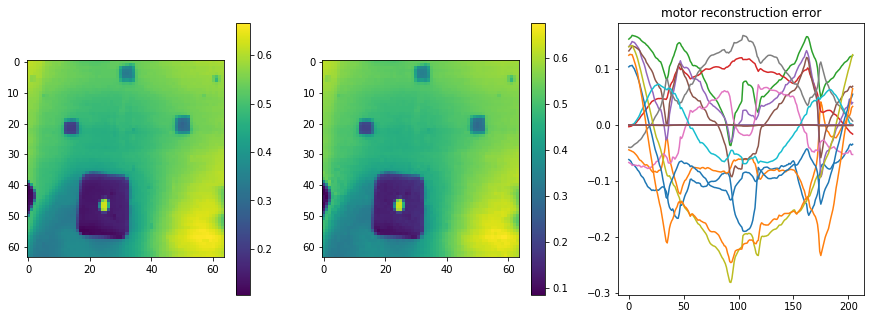

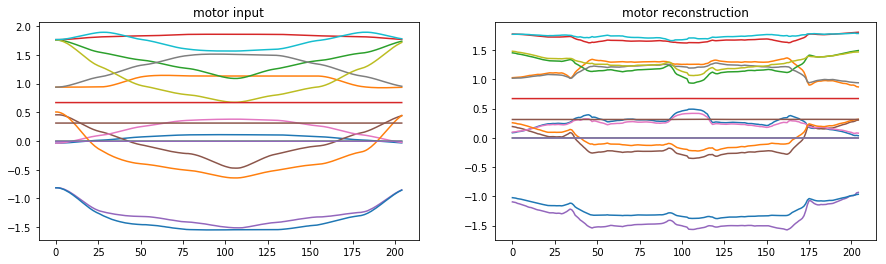

In [16]:
%matplotlib inline

samp = 10

visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

visual_output, motor_output, mu, logsig = vae(visual_input, motor_input, False)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(visual_input[8,:,:,:].squeeze().cpu().detach().numpy())
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(visual_output[8,:,:,:].squeeze().cpu().detach().numpy())
plt.colorbar()

plt.subplot(1,3,3)
plt.plot(motor_input.cpu()-motor_output.cpu().detach().numpy())
plt.title('motor reconstruction error')


plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(motor_input.cpu()*2.)
plt.title('motor input')
plt.subplot(1,2,2)
plt.plot(motor_output.cpu().detach().numpy()*2.)
plt.title('motor reconstruction')




Text(0.5,1,'activation of the latent variables for one sequence')

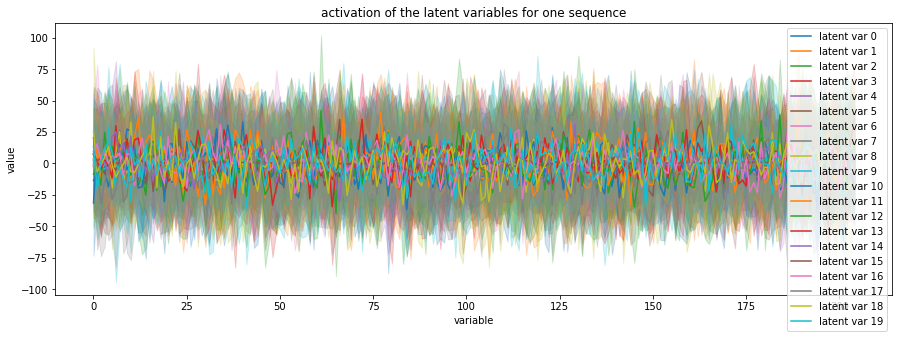

In [15]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

visual_output, motor_output, mu, logsig = vae(visual_input, motor_input, True)

mu = mu.cpu().detach().numpy()
sigma = logsig.cpu().detach().numpy()

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        im2 = cv2.resize(visual_output[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,10)
        fontScale              = 0.4
        fontColor              = (255,255,255)
        lineType               = 1

        cv2.putText(final_frame,'Ground truth', (100,20), font, fontScale, fontColor, lineType)
        cv2.putText(final_frame,'Reconstruction', (400,20), font, fontScale, fontColor, lineType)
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

plt.figure(figsize=(15,5))
x = np.linspace(0, len(mu))
for i in range(mu.shape[1]):
    data = mu[:,i] + np.random.rand(10, len(mu)) + np.random.randn(10, len(sigma))*np.exp(sigma[:,i])*40
    df = pd.DataFrame(data).melt()
    sns.lineplot(x="variable", y="value", data=df, ci='sd', label='latent var {}'.format(i))
plt.title('activation of the latent variables for one sequence')

# now we can encode the initial image and 'joint' positions into a latent state and feed it into and RNN for trajectory generation


In [14]:
# torch.save(vae.state_dict(), 'checkpoint_vae_hidden_states_1')
# vae.load_state_dict(torch.load('checkpoint_vae_hidden_states'))

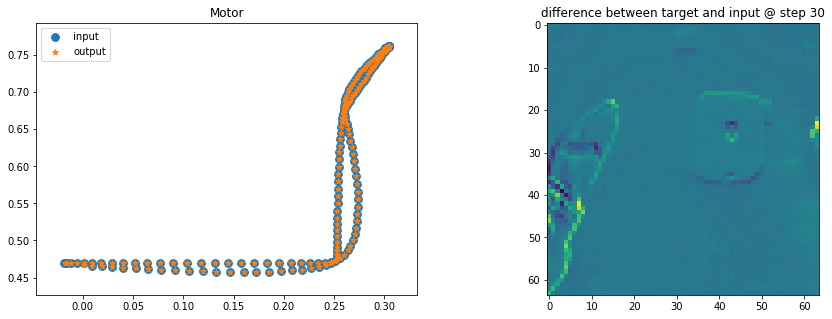

In [21]:
# visualize a training sequence:

(visual_input,
 motor_input, 
 visual_target, 
 motor_target) = dl.get_sample(device)

%matplotlib inline
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,5))
ax0.scatter(motor_input[:,0].cpu(), motor_input[:,1].cpu(), marker='o', s=60, label='input')
ax0.scatter(motor_target[:,0].cpu(), motor_target[:,1].cpu(), marker='*', label='output')
ax0.set(title='Motor')
ax1.set(title='difference between target and input @ step 30')
ax1.imshow(visual_input[30].cpu().squeeze() - visual_target[30].cpu().squeeze())
ax0.legend()

def loss_balancer2(vl, ml, motor_boost):
    total_loss_ = vl + ml
    visual_mult = total_loss_ / 2.0 / vl
    motor_mult = total_loss_ / 2.0 / ml * motor_boost
    s = visual_mult + motor_mult
    return visual_mult/s, motor_mult/s

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class RNNe(nn.Module):
    def __init__(self, cell_type, motor_input_size, hidden_size, num_rnn_layers):
        super(RNNe, self).__init__()                  # extend the functionality of previously built classes.
        self.cell_type = cell_type
        self.num_rnn_layers = num_rnn_layers

        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
            
            
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=(1,1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=(1,1))
        
        self.fc1 =   nn.Linear(4096, 100)
        self.fc11 =  nn.Linear(100 + motor_input_size, hidden_size)
           
        self.fc2 =   nn.Linear(hidden_size, 1024)
        self.fc3 =   nn.Linear(hidden_size, motor_input_size)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6, stride=2)


        self.optimizer = optim.Adam(self.parameters())        
    
       
    def forward(self, visual_input, motor_input, hidden):
        # visual pathway:
        out = F.relu(self.conv1(visual_input))                          # torch.Size([?, 7, 64, 64])
        out = F.relu(self.conv2(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv3(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv4(out))                                   # torch.Size([?, 28, 32, 32])

        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3])   # torch.Size([?, 7168])
        out = F.relu(self.fc1(out))                                     # torch.Size([?, 500])
        
        out = torch.cat((out, motor_input), dim=1).unsqueeze_(1)
        
        out = F.relu(self.fc11(out))
              
        
                      
        # run this combined input through an RNN cell (to predict the next visual input and motor state):
        out, hidden = self.rnn_cell(out, hidden)
        
        out1 = F.relu(self.fc2(out.squeeze()).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                               # torch.Size([?, 64])
        video_out = torch.sigmoid(self.deconv4(out1))                   # torch.Size([?, 64])
        
        # predict motor output based on the latent representation:
        motor_out = torch.tanh(self.fc3(out.squeeze()))

        return video_out, motor_out, hidden
    
    
    
    

motor_input_size= 16
hidden_size = 20

cell_type = 'GRU'
num_rnn_layers = 1


device = 'cuda'

motor_criterion = nn.MSELoss()
visual_criterion = nn.MSELoss()

# visual_criterion = nn.BCELoss(reduction='sum')

rnn = RNNe(cell_type, motor_input_size, hidden_size, num_rnn_layers).to(device)
# rnn.load_state_dict(torch.load('checkpoint_rnn_new_2'))

In [23]:
VLOSS, MLOSS = [], []

Progress: |-------------------------| 0.0% Complete

<IPython.core.display.Javascript object>


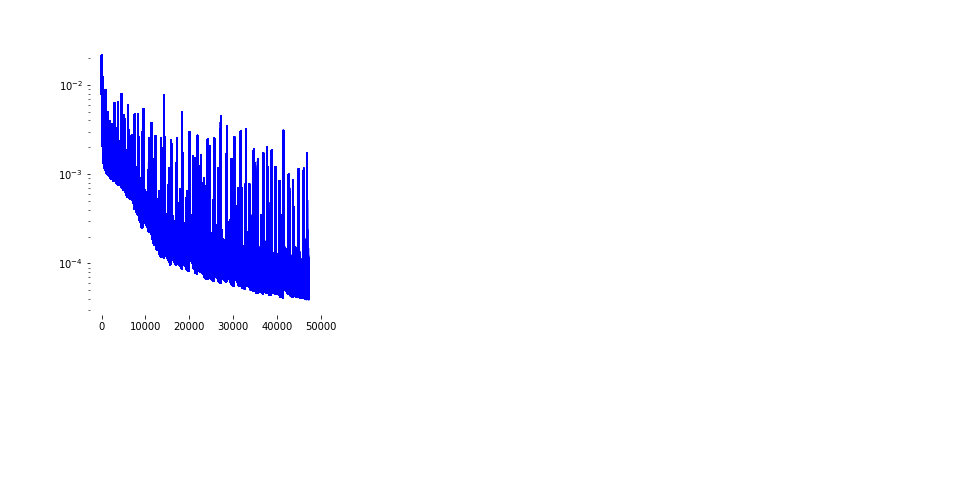

Epoch: 049300 vloss: 0.00 mloss: 0.000001 |████---------------------| 19.7% Complete
Stopped


In [35]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

EPOCHS = 250000

rnn.optimizer = optim.Adam(rnn.parameters())

mloss_boost = 1

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
fig.show()

for epoch in range(EPOCHS):
    try:
        rnn.optimizer.zero_grad()
        
        visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

        # mu will be used as the initial hidden state. We forward only the first 
        # frame and joint angles @ t=0  to get the hidden state.
        with torch.no_grad():
            _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), False) 
            hidden = mu.unsqueeze(1)/2.

        visual_output, motor_output, hidden = rnn(visual_input[1:, :,:,:].view(-1,1,64,64),
                                          motor_input[1:, :].view(-1, motor_input_size), hidden)

        motor_loss = motor_criterion(motor_output, motor_target[1:, :].view(-1, motor_input_size))
        visual_loss = visual_criterion(visual_output, visual_target[1:,:,:,:].view(-1,1,64,64))
        
        visual_mult, motor_mult = loss_balancer2(visual_loss.item(), motor_loss.item(), mloss_boost)
        loss = motor_mult*motor_loss + visual_mult*visual_loss
#         loss = motor_loss + visual_loss
        
        loss.backward()
        
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        
        rnn.optimizer.step()
       
        printProgressBar(epoch + 1,
                         EPOCHS, 
                         prefix='Epoch: {} vloss: {:.2f} mloss: {:.6f}'.format(
                             str(epoch).zfill(6),
                             visual_loss.item(),
                             motor_loss.item()), 
                         suffix='Complete',
                         length=25)
        
        if epoch % 1000 == 0:
            torch.save(rnn.state_dict(), 'checkpoint_rnn_new_3')
            
        if epoch % 100 == 0:
            ax0.plot(VLOSS, c='b')
            ax0.set(title='Visual loss')
            ax0.set_yscale('log')
            ax1.plot(MLOSS, c='b')
            ax1.set(title='Motor loss')
            ax1.set_yscale('log')
            fig.canvas.draw()
            
            
    except KeyboardInterrupt:
        %matplotlib inline
        print('\nStopped')
        break
        

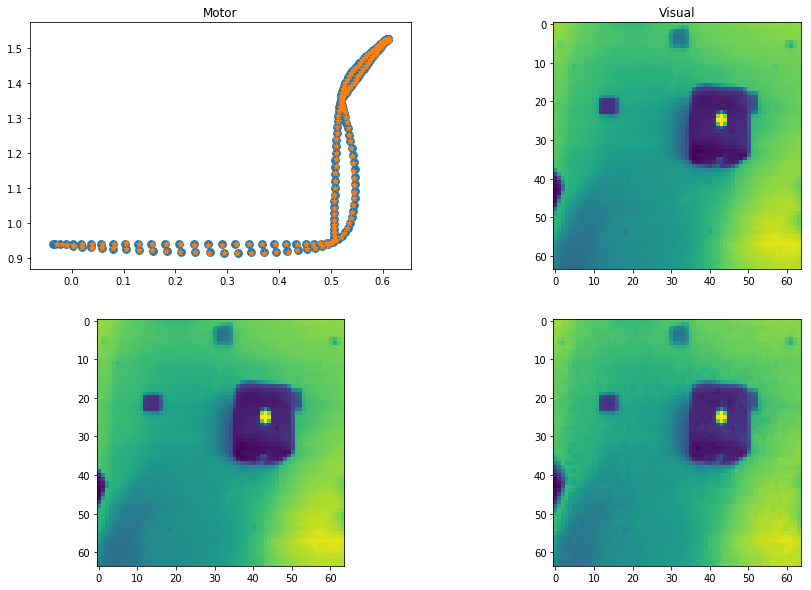

In [38]:
%matplotlib inline

visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)


with torch.no_grad():
    _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), False) 
    hidden = mu.unsqueeze(1)/2.
            
visual_output, motor_output, hidden = rnn(visual_input[1:, :,:,:].view(-1,1,64,64),
                                  motor_input[1:, :].view(-1, motor_input_size), hidden)


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
ax0.scatter(motor_target[:,0].cpu().detach().numpy() * 2.,
            motor_target[:,1].cpu().detach().numpy() * 2., marker='o', s=60, label='input')
ax0.scatter(motor_output[:,0].cpu().detach().numpy() * 2.,
            motor_output[:,1].cpu().detach().numpy() * 2., marker='*', label='output')
ax0.set(title='Motor')
ax1.set(title='Visual')
ax1.imshow(visual_input[4].cpu().detach().numpy().squeeze() + visual_target[4].cpu().detach().numpy().squeeze())

ax2.imshow(visual_input[4].cpu().detach().numpy().squeeze())
ax3.imshow(visual_output[4].cpu().detach().numpy().squeeze())


In [40]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

with torch.no_grad():
    _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), True) 
    hidden = mu.unsqueeze(1)/2.
            
visual_output, motor_output, hidden = rnn(visual_input[1:, :,:,:].view(-1,1,64,64),
                                  motor_input[1:, :].view(-1, motor_input_size), hidden)

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        im2 = cv2.resize(visual_output[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,10)
        fontScale              = 0.4
        fontColor              = (255,255,255)
        lineType               = 1

        cv2.putText(final_frame,'Ground truth', (100,20), font, fontScale, fontColor, lineType)
        cv2.putText(final_frame,'Prediction of next step', (400,20), font, fontScale, fontColor, lineType)
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

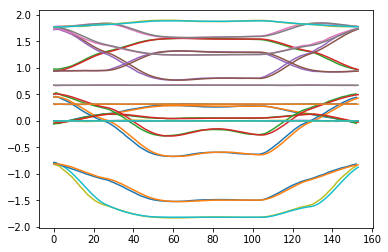

In [33]:
for j in range(16):
    plt.plot(motor_output.cpu().detach().numpy()[:,j]*2.)
    plt.plot(motor_input.cpu().detach().numpy()[:,j]*2.)

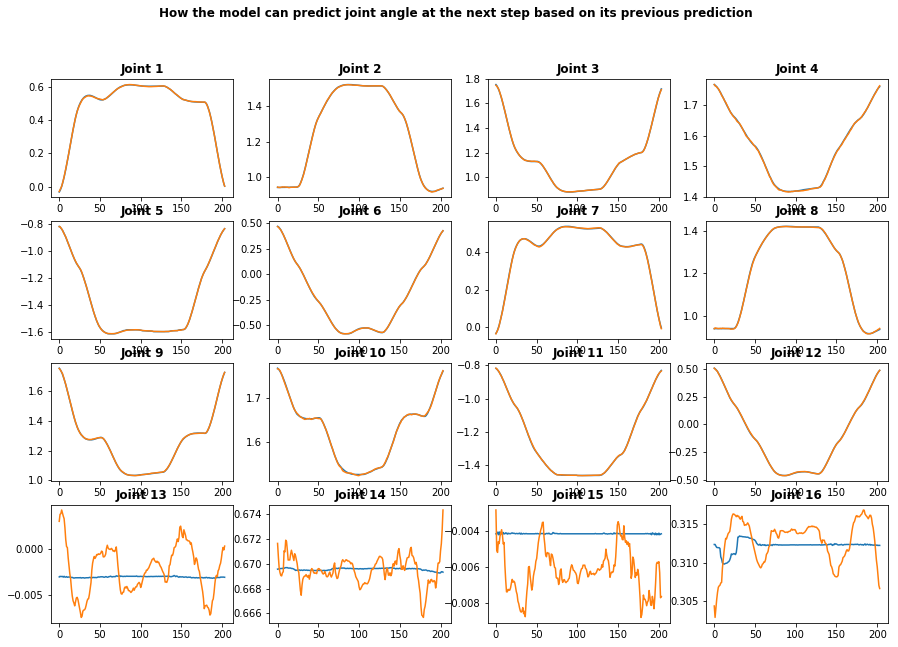

In [43]:
visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)


with torch.no_grad():
    _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), True) 
    hidden = mu.unsqueeze(1)/2.

motor_output = motor_input[0,:]

gt, pred = [], []
for i in range(1, len(visual_input)):
    visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].view(-1,1,64,64),
                                              motor_output.view(-1, motor_input_size),
                                              hidden)
    
    gt.append(motor_target[i,:].detach().cpu().numpy())
    pred.append(motor_output.squeeze().detach().cpu().numpy())
gt = np.stack(gt)*2.
pred = np.stack(pred)*2.

plt.figure(figsize=(15,10))
plt.suptitle('How the model can predict joint angle at the next step based on its previous prediction', weight='bold')
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title('Joint {}'.format(i+1), weight='bold')
    plt.plot(gt[:, i])
    plt.plot(pred[:, i])

In [2]:
tracker = Tracker()
tracker.start()
time.sleep(0.2)


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)
    time.sleep(2)

while True:
    
    hor, ver = tracker.new_hor, tracker.new_ver
    
    
    torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                          joint_ids = [0, 1, 2, 3],
                          positions=[0, np.radians(38.0), hor, ver],
                          velocities=None,
                          accelerations=None,
                          duration=0.5)
    try:
        cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    except:
        print('error')
        break
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        tracker.stop()
        break
    
    time.sleep(1)

NameError: name 'Tracker' is not defined